In [1]:
import pandas as pd
import numpy as np
import os
from keras.layers import Dense, Flatten, AveragePooling2D, Activation, Dropout ,Input, Lambda
from keras.models import Model
from tensorflow.keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input
from keras.models import Sequential
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.segmentation import mark_boundaries
import lime
from lime import lime_image
import cv2
from tensorflow.keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input

In [2]:
data_path = 'Data'
IMAGE_SIZE = [224, 224]

In [3]:
denseNet121 = DenseNet121(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [4]:
for layer in denseNet121.layers:
    layer.trainable = False
denseNet121.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [18]:
headModel2 = Sequential()
headModel2.add(AveragePooling2D(pool_size=(4,4), input_shape=denseNet121.output_shape[1:], name="AveragePooling2DDd"))
headModel2.add(Flatten( name ="Flatten"))
headModel2.add(Dense(256, activation ="relu"))
headModel2.add(Dropout(0.2, name="Dropout2"))
headModel2.add(Dense(3, activation="softmax"))

In [19]:
headModel2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
AveragePooling2DDd (AverageP (None, 1, 1, 1024)        0         
_________________________________________________________________
Flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               262400    
_________________________________________________________________
Dropout2 (Dropout)           (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 771       
Total params: 263,171
Trainable params: 263,171
Non-trainable params: 0
_________________________________________________________________


In [20]:
model = Sequential()
model.add(denseNet121)
model.add(headModel2)

In [21]:
input_shape = (None, 224, 224, 3)

In [22]:
model.build(input_shape)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_1 (ModuleWrap (None, 7, 7, 1024)        7037504   
_________________________________________________________________
sequential_2 (Sequential)    (None, 3)                 263171    
Total params: 7,300,675
Trainable params: 263,171
Non-trainable params: 7,037,504
_________________________________________________________________


In [23]:
from keras.optimizers import Adam
Optimizer=Adam(learning_rate=0.001)
model.compile(optimizer=Optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [24]:
datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=20,zoom_range=0.2,
                    width_shift_range=0.2,height_shift_range=0.2,shear_range=0.1,fill_mode="nearest")
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,
                                   rotation_range=15,
                                   horizontal_flip = True,
                                   vertical_flip=True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.1,
                                   fill_mode="nearest")

test_datagen = ImageDataGenerator(rescale = 1./255)

training_gen = train_datagen.flow_from_directory(data_path + '/train',
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

test_gen = test_datagen.flow_from_directory(data_path + '/test',
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'categorical',
                                            shuffle = False)

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [25]:
history1 = model.fit(training_gen,validation_data=test_gen,epochs=50)

Epoch 1/50
322/322 [==============================] - 697s 2s/step - loss: 0.5942 - accuracy: 0.7664 - val_loss: 0.2653 - val_accuracy: 0.8975
Epoch 2/50
322/322 [==============================] - 556s 2s/step - loss: 0.3195 - accuracy: 0.8737 - val_loss: 0.2528 - val_accuracy: 0.8998
Epoch 3/50
322/322 [==============================] - 559s 2s/step - loss: 0.3194 - accuracy: 0.8692 - val_loss: 0.3236 - val_accuracy: 0.8688
Epoch 4/50
322/322 [==============================] - 553s 2s/step - loss: 0.3015 - accuracy: 0.8794 - val_loss: 0.3597 - val_accuracy: 0.8478
Epoch 5/50
322/322 [==============================] - 554s 2s/step - loss: 0.2821 - accuracy: 0.8947 - val_loss: 0.2803 - val_accuracy: 0.8797
Epoch 6/50
322/322 [==============================] - 555s 2s/step - loss: 0.2738 - accuracy: 0.8891 - val_loss: 0.2871 - val_accuracy: 0.8843
Epoch 7/50
322/322 [==============================] - 555s 2s/step - loss: 0.2843 - accuracy: 0.8937 - val_loss: 0.2614 - val_accuracy: 0.8913

In [26]:
model.evaluate(training_gen,verbose=1)

322/322 [==============================] - 513s 2s/step - loss: 0.1771 - accuracy: 0.9310


[0.1770913004875183, 0.930987536907196]

In [27]:
model.evaluate(test_gen,verbose=1)

81/81 [==============================] - 123s 2s/step - loss: 0.2243 - accuracy: 0.9014


[0.22429993748664856, 0.9013975262641907]

In [51]:
model.evaluate(test_gen,verbose=4)

[0.22429993748664856, 0.9013975262641907]

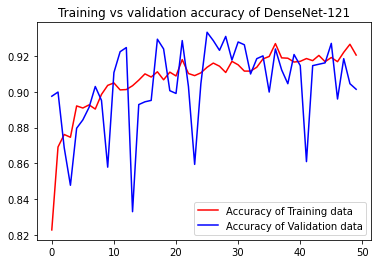

<Figure size 432x288 with 0 Axes>

In [28]:
get_acc = history1.history['accuracy']
value_acc = history1.history['val_accuracy']
get_loss = history1.history['loss']
validation_loss = history1.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy of DenseNet-121')
plt.legend(loc=0)
plt.figure()
plt.show()

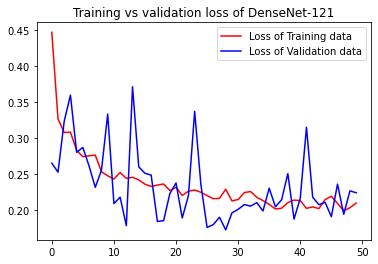

<Figure size 432x288 with 0 Axes>

In [29]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss of DenseNet-121')
plt.legend(loc=0)
plt.figure()
plt.show()

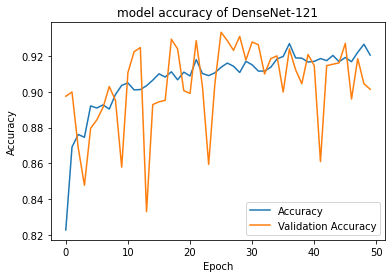

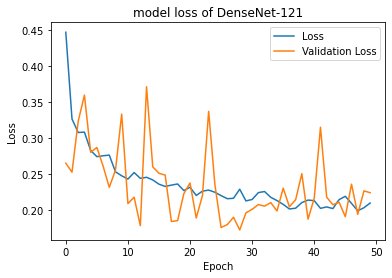

In [30]:
import matplotlib.pyplot as plt
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title("model accuracy of DenseNet-121")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title("model loss of DenseNet-121")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()

In [111]:
y_predictions=[]
for img in os.listdir("Data/test/COVID19"):
    img = load_img('Data/test/COVID19/'+img,target_size=(224,224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    result = model.predict(img/255.0)[0]
    y_predictions.append(np.argmax(result))

for img in os.listdir("Data/test/NORMAL"):
    img = load_img('Data/test/NORMAL/'+img,target_size=(224,224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    result = model.predict(img/255.0)[0]
    y_predictions.append(np.argmax(result))
    
for img in os.listdir("Data/test/PNEUMONIA"):
    img = load_img('Data/test/PNEUMONIA/'+img,target_size=(224,224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    result = model.predict(img/255.0)[0]
    y_predictions.append(np.argmax(result))

y_predictions=np.array(y_predictions)

In [112]:
print(classification_report(test_gen.classes,y_predictions))

              precision    recall  f1-score   support

           0       0.99      0.91      0.95       116
           1       0.74      0.95      0.83       317
           2       0.97      0.88      0.93       855

    accuracy                           0.90      1288
   macro avg       0.90      0.91      0.90      1288
weighted avg       0.92      0.90      0.90      1288



In [113]:
print(confusion_matrix(test_gen.classes,y_predictions))

[[105   5   6]
 [  0 301  16]
 [  1  99 755]]


<AxesSubplot:>

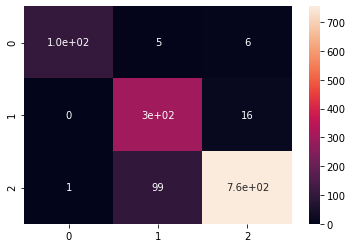

In [115]:
import seaborn as sns
sns.heatmap(confusion_matrix(test_gen.classes,y_predictions), annot=True)

In [116]:
auc_roc=metrics.classification_report(test_gen.classes,y_predictions)
auc_roc

'              precision    recall  f1-score   support\n\n           0       0.99      0.91      0.95       116\n           1       0.74      0.95      0.83       317\n           2       0.97      0.88      0.93       855\n\n    accuracy                           0.90      1288\n   macro avg       0.90      0.91      0.90      1288\nweighted avg       0.92      0.90      0.90      1288\n'

In [124]:
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize

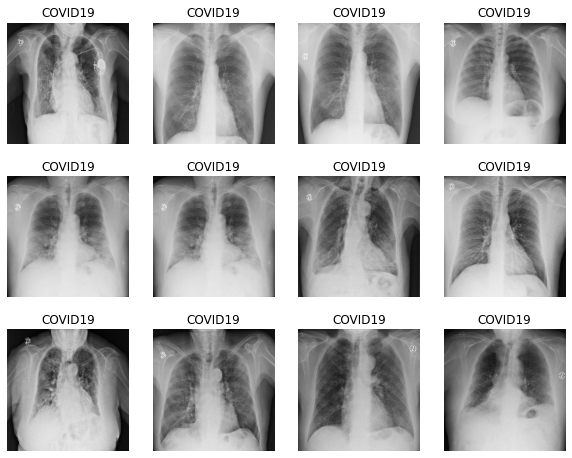

In [132]:
labels = ['COVID19', 'NORMAL', 'PNEUMONIA']

sample_data = test_gen.__getitem__(1)[0] 
sample_label = test_gen.__getitem__(1)[1] 

plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    plt.imshow(sample_data[i])
    plt.title(labels[np.argmax(sample_label[i])])

In [138]:
import os
import numpy as np
import cv2                 
from random import shuffle
from tqdm import tqdm  
import tensorflow as tf 
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from collections import Counter

In [139]:
last_conv_layer_name = "top_conv"
classifier_layer_names = [
    "top_bn",
    "top_activation",
    "averagepooling2d_head",
    "flatten_head",
    "dense_head",
    "dropout_head",
    "predictions_head"
]

NameError: name 'top_index' is not defined

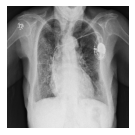

In [142]:
plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    #heatmap, top_index = make_gradcam_heatmap(np.expand_dims(sample_data[i], axis=0), model_efnet, last_conv_layer_name, classifier_layer_names)
    img = np.uint8(255 * sample_data[i])
    #s_img = superimposed_img(img, heatmap)
    plt.imshow(img)
    plt.title(labels[np.argmax(sample_label[i])] + " pred as: " + labels[top_index], fontsize=8)

NameError: name 'labels' is not defined

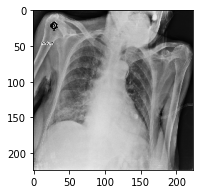

In [129]:
import tensorflow as tf

plt.figure(figsize=(20,10))
for i in range(0,9):
    
    plt.subplot(3, 3, i + 1)
    
    plt.imshow(test_gen.__getitem__(0)[0][i],cmap='gray')
    plt.title(labels[np.argmax(sample_label[i])] + " pred as: " + labels[top_index], fontsize=8)
    #plt.title(f"   Real: {getLabel(y_test[i])   } Vs  Predict: {getLabel(pred[i])}")

In [31]:
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize

In [32]:
from sklearn.metrics import precision_score, recall_score,\
                            confusion_matrix, classification_report, \
                            accuracy_score, f1_score

In [33]:
class_dict = {0:'COVID19',1:'NORMAL',2:'PNEUMONIA'}

In [105]:
pred=model.predict(test_gen)

In [106]:
print(len(pred))

1288


In [107]:
y_test=[]
for i in range(81):
    y_test.extend(test_gen.__getitem__(i)[1])

In [108]:
print(len(y_test))
y_test=np.array(y_test)

1288


In [101]:
#y_test=np.argmax(y_test,axis=0)
#pred= np.argmax(pred,axis=0)

In [102]:
#print("pred \n",len(pred))
#print("y_test \n",len(y_test))

TypeError: object of type 'numpy.int64' has no len()

In [103]:
#print("y_test \n",y_test)
#print("pred \n",pred)

y_test 
 433
pred 
 62


In [109]:
print(classification_report(test_gen.classes,pred))

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

In [42]:
print(confusion_matrix(test_gen.classes,pred))

[[105   5   6]
 [  0 301  16]
 [  1  99 755]]


<AxesSubplot:>

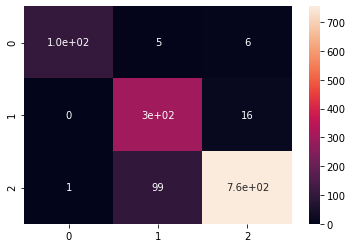

In [43]:
import seaborn as sns
sns.heatmap(confusion_matrix(test_gen.classes,pred), annot=True)

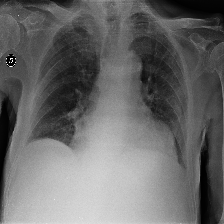

In [44]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
load_img("Data/test/COVID19/COVID19(461).jpg",target_size=(224,224))

In [45]:
image=load_img("Data/test/COVID19/COVID19(461).jpg",target_size=(224,224))

image=img_to_array(image) 
image=image/255.0
prediction_image=np.array(image)
prediction_image= np.expand_dims(image, axis=0)

In [46]:
reverse_mapping={0:'COVID19', 1:'NORMAL', 2:'PNEUMONIA'}

def mapper(value):
    return reverse_mapping[value]

prediction=model.predict(prediction_image)
value=np.argmax(prediction)
move_name=mapper(value)
print("Prediction is {}.".format(move_name))

Prediction is COVID19.


pneumonia
[[0.00923957 0.00254113 0.98821926]]


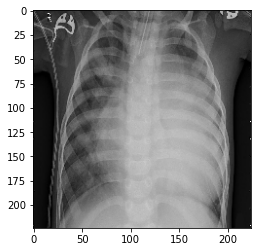

In [86]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
img = image.load_img("Data/test/PNEUMONIA/PNEUMONIA(3421).jpg",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
from keras.models import load_model
output = model.predict(img)
if output[0][0] > output[0][1] and output[0][0] > output[0][2]:
    print("covid")
elif output[0][1]>output[0][2] and output[0][1]>output[0][2]:
    print("Normal")
else:
    print("pneumonia")
    print(output)
    

In [52]:
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc

In [92]:
auc_roc=metrics.classification_report(test_gen.classes,pred)
auc_roc

'              precision    recall  f1-score   support\n\n           0       0.99      0.91      0.95       116\n           1       0.74      0.95      0.83       317\n           2       0.97      0.88      0.93       855\n\n    accuracy                           0.90      1288\n   macro avg       0.90      0.91      0.90      1288\nweighted avg       0.92      0.90      0.90      1288\n'

In [97]:
auc_roc=metrics.roc_auc_score(y_test,pred, multi_class="ovr")
auc_roc

ValueError: Found input variables with inconsistent numbers of samples: [416, 1288]

In [123]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

ValueError: multilabel-indicator format is not supported

In [57]:
from sklearn.metrics import roc_auc_score

# actual

In [50]:
prediction4 = np.argmax(model.predict(test_gen), axis = -1)
prediction4

array([0, 0, 0, ..., 2, 2, 2], dtype=int64)

NameError: name 'getLabel' is not defined

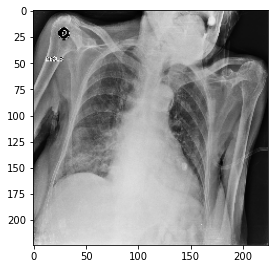

In [121]:
y_test4=[]
for i in range(41):
    y_test4.extend(test_gen.__getitem__(i)[1])
y_test4=np.array(y_test4)
plt.figure(figsize=(20,10))
fig = plt.gcf()
ncolumns,nrows=5,5
fig.set_size_inches(ncolumns*5, nrows*5)
for i in range(25):
    plt.subplot(nrows, ncolumns, i + 1)
    plt.imshow(test_gen.__getitem__(0)[0][i],cmap='gray')
    plt.title(f"REAL: {getLabel(y_test4[i])   } vs  PREDICT: {getLabel(prediction4[i])}")

In [ ]:
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize

TypeError: 'dict' object is not callable

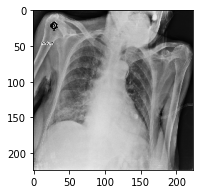

In [145]:
plt.figure(figsize=(20,10))
for i in range(0,9):
    
    plt.subplot(3, 3, i + 1)
    
    plt.imshow(test_gen.__getitem__(0)[0][i],cmap='gray')
    plt.title(f"   Real: {getLabel(y_test[i])   } Vs  Predict: {getLabel(y_predictions[i])}")